<a href="https://colab.research.google.com/github/M4700F/CSE-4622-ML-Lab-Term-Project/blob/Maroof/adversarial_attack_on_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from google.colab import drive
import random

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
IMG_SIZE = 224  # 224x224 as mentioned in paper
NUM_SAMPLES = 500

In [4]:
dataset_path = '/content/drive/MyDrive/data'
train_path = os.path.join(dataset_path, 'train')
test_path = os.path.join(dataset_path, 'test')

In [5]:
train_benign_path = os.path.join(train_path, 'benign')
train_malignant_path = os.path.join(train_path, 'malignant')
test_benign_path = os.path.join(test_path, 'benign')
test_malignant_path = os.path.join(test_path, 'malignant')

In [6]:
print("Checking dataset structure...")
print(f"Dataset folder exists: {os.path.exists(dataset_path)}")
print(f"Train folder exists: {os.path.exists(train_path)}")
print(f"Test folder exists: {os.path.exists(test_path)}")

Checking dataset structure...
Dataset folder exists: True
Train folder exists: True
Test folder exists: True


In [7]:
print("\nTrain folders:")
print(f"  Train/Benign exists: {os.path.exists(train_benign_path)}")
print(f"  Train/Malignant exists: {os.path.exists(train_malignant_path)}")

print("\nTest folders:")
print(f"  Test/Benign exists: {os.path.exists(test_benign_path)}")
print(f"  Test/Malignant exists: {os.path.exists(test_malignant_path)}")


Train folders:
  Train/Benign exists: True
  Train/Malignant exists: True

Test folders:
  Test/Benign exists: True
  Test/Malignant exists: True


In [8]:
train_benign_count = len([f for f in os.listdir(train_benign_path) if f.endswith('.jpg')])
print(f"  Train/Benign images: {train_benign_count}")

train_malignant_count = len([f for f in os.listdir(train_malignant_path) if f.endswith('.jpg')])
print(f"  Train/Malignant images: {train_malignant_count}")

test_benign_count = len([f for f in os.listdir(test_benign_path) if f.endswith('.jpg')])
print(f"  Test/Benign images: {test_benign_count}")

test_malignant_count = len([f for f in os.listdir(test_malignant_path) if f.endswith('.jpg')])
print(f"  Test/Malignant images: {test_malignant_count}")


  Train/Benign images: 1440
  Train/Malignant images: 1197
  Test/Benign images: 360
  Test/Malignant images: 300


### Load images

In [9]:
def load_images(folder_path, label, max_samples=500):
    images = []
    labels = []

    # Get all jpg files
    files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

    # Randomly select max_samples files
    if len(files) > max_samples:
        files = random.sample(files, max_samples)

    print(f"Loading {len(files)} images from {folder_path.split('/')[-1]} folder...")

    for i, filename in enumerate(files):
        try:
            # Load and resize image
            img_path = os.path.join(folder_path, filename)
            img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
            img_array = img_to_array(img)
            img_array = img_array / 255.0  # Normalize to [0,1]

            images.append(img_array)
            labels.append(label)

            if (i + 1) % 100 == 0:
                print(f"  Processed {i + 1}/{len(files)} images")

        except Exception as e:
            print(f"  Error loading {filename}: {e}")
            continue

    return np.array(images), np.array(labels)

In [10]:
train_benign_images, train_benign_labels = load_images(train_benign_path, 0, NUM_SAMPLES)  # 0 for benign
train_malignant_images, train_malignant_labels = load_images(train_malignant_path, 1, NUM_SAMPLES)  # 1 for malignant

Loading 500 images from benign folder...
  Processed 100/500 images
  Processed 200/500 images
  Processed 300/500 images
  Processed 400/500 images
  Processed 500/500 images
Loading 500 images from malignant folder...
  Processed 100/500 images
  Processed 200/500 images
  Processed 300/500 images
  Processed 400/500 images
  Processed 500/500 images


In [12]:
# Combine training data
X_train = np.concatenate([train_benign_images, train_malignant_images], axis=0)
y_train = np.concatenate([train_benign_labels, train_malignant_labels], axis=0)

In [13]:
test_benign_images, test_benign_labels = load_images(test_benign_path, 0, NUM_SAMPLES)  # 0 for benign
test_malignant_images, test_malignant_labels = load_images(test_malignant_path, 1, NUM_SAMPLES)  # 1 for malignant

Loading 360 images from benign folder...
  Processed 100/360 images
  Processed 200/360 images
  Processed 300/360 images
Loading 300 images from malignant folder...
  Processed 100/300 images
  Processed 200/300 images
  Processed 300/300 images


In [14]:
# Combine test data
X_test = np.concatenate([test_benign_images, test_malignant_images], axis=0)
y_test = np.concatenate([test_benign_labels, test_malignant_labels], axis=0)

In [15]:
print(f"\n=== Dataset Summary ===")
print(f"Training set:")
print(f"  Total images: {len(X_train)}")
print(f"  Benign images: {np.sum(y_train == 0)}")
print(f"  Malignant images: {np.sum(y_train == 1)}")


=== Dataset Summary ===
Training set:
  Total images: 1000
  Benign images: 500
  Malignant images: 500


In [16]:
print(f"\nTest set:")
print(f"  Total images: {len(X_test)}")
print(f"  Benign images: {np.sum(y_test == 0)}")
print(f"  Malignant images: {np.sum(y_test == 1)}")


Test set:
  Total images: 660
  Benign images: 360
  Malignant images: 300


In [17]:
print(f"\nImage specifications:")
print(f"  Image shape: {X_train[0].shape}")
print(f"  Pixel value range: [{X_train.min():.3f}, {X_train.max():.3f}]")


Image specifications:
  Image shape: (224, 224, 3)
  Pixel value range: [0.000, 1.000]


In [18]:
# Step 10: Display sample images
def display_sample_images(X, y, title="Sample Images", num_samples=6):
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.ravel()

    for i in range(num_samples):
        idx = random.randint(0, len(X) - 1)
        img = X[idx]
        label = 'Malignant' if y[idx] == 1 else 'Benign'

        axes[i].imshow(img)
        axes[i].set_title(f'{label}')
        axes[i].axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


=== Displaying Sample Training Images ===


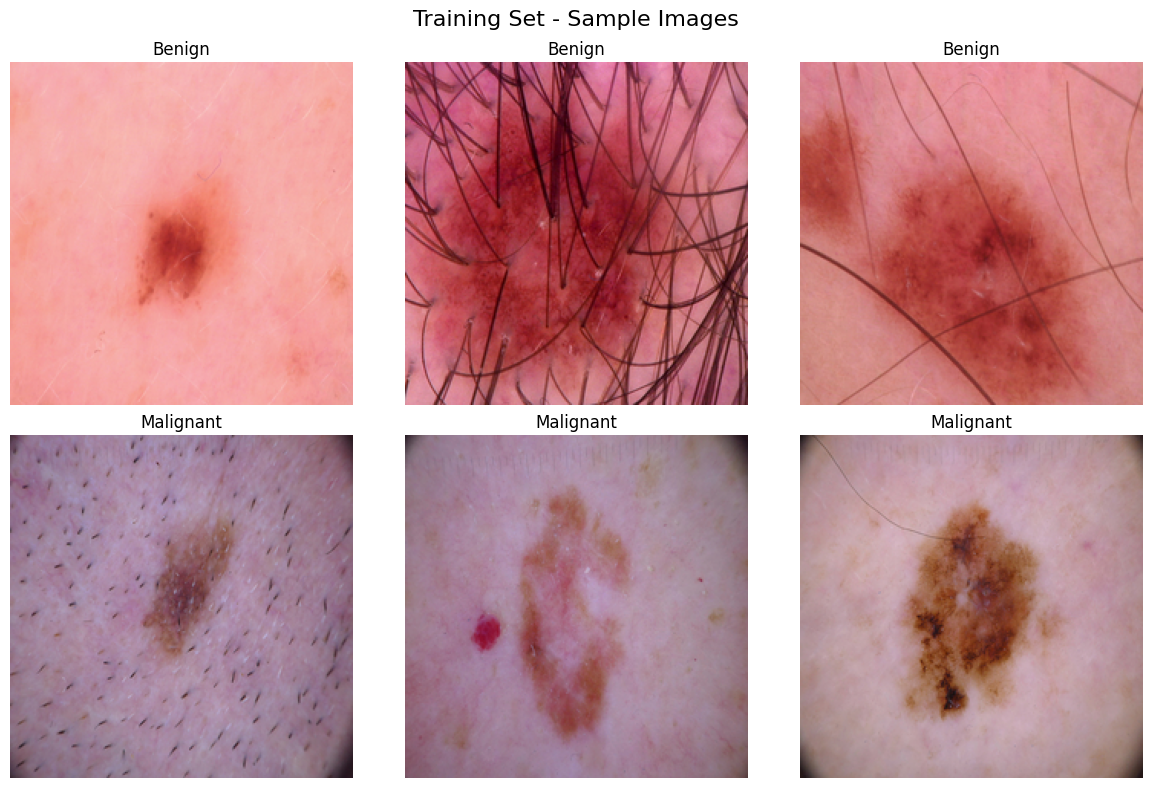


Dataset loading completed successfully!

Variables created:
- X_train: Training images
- X_test: Test images
- y_train: Training labels (0=benign, 1=malignant)
- y_test: Test labels (0=benign, 1=malignant)


In [19]:
# Display sample images from training set
print("\n=== Displaying Sample Training Images ===")
display_sample_images(X_train, y_train, "Training Set - Sample Images")

print("\nDataset loading completed successfully!")
print("\nVariables created:")
print("- X_train: Training images")
print("- X_test: Test images")
print("- y_train: Training labels (0=benign, 1=malignant)")
print("- y_test: Test labels (0=benign, 1=malignant)")